In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import mahakala as ma

from mahakala.grmhd.athenak import AthenakFluidModel
from mahakala.electrons import rlow_rhigh_model

from mahakala.constants import Msun

# make image

### specify fluid and image parameters

In [3]:
# fluid model
grmhd_fname = 'torus.mhd_w_bcc.01980.athdf'
bhspin = 0.9
fluid_gamma = 13./9

# camera location
inclination_in_degrees = 60
distance_in_rg = 1000

# thermodynamics and scaling parameters
Mass_scale = 1e+26
M_bh = 6.2e9 * Msun
r_high = 40

# image properties
observing_frequency = 230.e9
half_fov = 10
number_pixels_across = 160

### load fluid model

In [4]:
fluid_model = AthenakFluidModel(grmhd_fname, bhspin)

100%|██████████| 456/456 [00:01<00:00, 387.12it/s]


### get geodesics

In [5]:
s0 = ma.initialize_geodesics_at_camera(bhspin, inclination_in_degrees, distance_in_rg, -half_fov, half_fov, number_pixels_across)

S, final_dt = ma.geodesic_integrator(10000, s0, 40, 1e-4, bhspin)

### sample fluid model at geodesic points and compute supplemental quantities

In [6]:
fluid_scalars = fluid_model.get_fluid_scalars_from_geodesics(S)

100%|██████████| 456/456 [00:32<00:00, 13.85it/s]


In [7]:
# compute derived quantities
bsq = fluid_scalars['b'] * fluid_scalars['b']
beta = fluid_scalars['u'] * (fluid_gamma - 1.) / bsq / 0.5
beta.at[np.isnan(beta)].set(0.)
sigma = bsq / fluid_scalars['dens']
sigma.at[np.isnan(sigma)].set(0.)

# compute dimensionless electron temperature from rlow/rhigh model
Theta_e = rlow_rhigh_model(fluid_scalars['dens'], fluid_scalars['u'], beta, r_high=r_high)

# rescale GRMHD to cgs units
units = fluid_model.get_units(M_bh, Mass_scale)
Ne_in_cgs = units['Ne_unit'] * fluid_scalars['dens']
B_in_gauss = units['B_unit'] * fluid_scalars['b']
pitch_angle = fluid_scalars['pitch_angle']
local_nu = - fluid_scalars['kdotu'] * observing_frequency

### compute radiative transfer coefficients and solve the radiative transfer equation

In [8]:
emissivity, absorptivity = ma.synchrotron_coefficients(Ne_in_cgs, Theta_e, B_in_gauss, pitch_angle, local_nu, invariant=True, rescale_nu=1./observing_frequency)

# apply sigma cutoff
sigma_cutoff = 100.
emissivity = emissivity.at[sigma > sigma_cutoff].set(0.)
absorptivity = absorptivity.at[sigma > sigma_cutoff].set(0.)

I_nu = ma.solve_specific_intensity(emissivity, absorptivity, final_dt, units['L_unit'])

In [9]:
# regression test

image_comparison = np.load('image_comparison.npy')
print(np.allclose(image_comparison, I_nu))

True


# example plotting

In [10]:
def colorbar(im):
    # add colorbar to the right of the plot that is the same height
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(im.axes)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return im.axes.figure.colorbar(im, cax=cax)

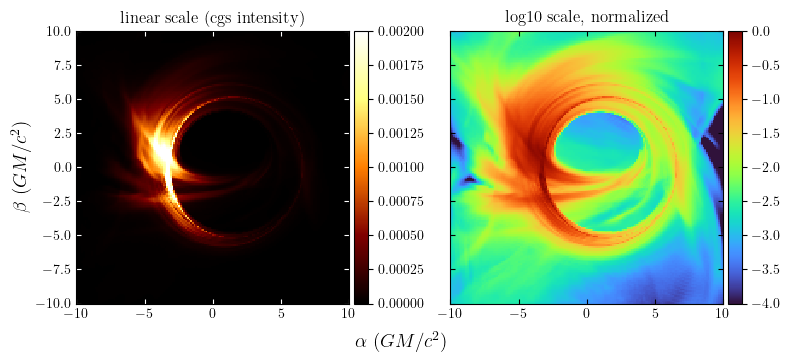

In [11]:
pdata = I_nu.reshape((number_pixels_across, number_pixels_across)).T

fig = plt.figure(figsize=(8, 4), facecolor='w')

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

kwargs = dict(extent=[-half_fov, half_fov, -half_fov, half_fov], aspect='equal', 
              interpolation='none', origin='lower', rasterized=True)

# show image in linear scale
im1 = ax1.imshow(pdata, vmin=0, vmax=0.002, cmap='afmhot', **kwargs)
colorbar(im1)
ax1.set_title('linear scale (cgs intensity)')
ax1.tick_params(direction='in', top=True, right=True, color='w')

# show image in log10 scale
pdata = pdata / np.max(pdata)
im2 = ax2.imshow(np.log10(pdata), vmin=-4, vmax=0., cmap='turbo', **kwargs)
colorbar(im2)
ax2.set_yticklabels([])
ax2.set_title('log10 scale, normalized')
ax2.tick_params(direction='in', top=True, right=True)

# add labels
fig.text(0.45, 0.05, r'$\alpha\ (GM/c^2)$', fontsize=14)
ax1.set_ylabel(r'$\beta\ (GM/c^2)$', fontsize=14)

plt.tight_layout()
plt.savefig('example_grmhd.pdf', bbox_inches='tight')